# Day 23 Data challenge 3: GHSL Global Human Settlement Layer 
### For Metropolitan Area of Mexico City (seeing the development)

In [166]:
import rasterio
import rasterio.mask
import numpy as np
import fiona
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

import geopandas as gpd
from rasterio.plot import plotting_extent
import rioxarray as rxr

Recorte de ráster por shp de ZMVM

In [47]:
with fiona.open("shapes/ZMVM3857.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

with rasterio.open('GHS_BUILT_LDSMT_GLOBE_R2018A_3857_30_V2_0_6_10/GHS_BUILT_LDSMT_GLOBE_R2018A_3857_30_V2_0_6_10.tif') as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta

Creación de ráster

In [50]:
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open("ZMVM_GHSL.tif", "w", **out_meta) as dest:
    dest.write(out_image)
    
dataset = rasterio.open('ZMVM_GHSL.tif')
image = dataset.read()

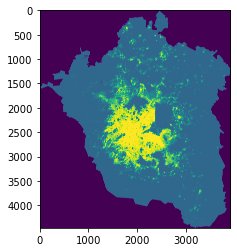

In [54]:
# use the matplotlib.pyplot function "imshow" for an image -- nir at first
fig, ax = plt.subplots()
ax.imshow(image[0, :, :])

Máscara donde los valores no se visualizan

In [92]:
#no data
image = np.ma.masked_where(image == 0 ,
                          image,
                          copy=True)

#land no built-up in any epoch
image = np.ma.masked_where(image == 2,
                          image,
                          copy=True)


In [135]:
ZMVM = gpd.read_file("shapes/ZMVM3857.shp")



In [155]:
data = rxr.open_rasterio('ZMVM_GHSL.tif', masked=True)
data_plotting_extent = plotting_extent(data[0], data.rio.transform())

# See coordinates of plotting extent
data_plotting_extent

(-11092980.0, -10975740.0, 2147310.0, 2281140.0)

In [156]:
# Define the colors you want
cmap = ListedColormap(["#F71735", "#FECF8C", "#41EAD4", "#FDFFFC", "#FF9F1C"])

Text(0.96, 0.01, 'Elaborado con datos de:\nGHS_BUILT_LDSMT_GLOBE_R2018A \n doi:10.2905/jrc-ghsl-10007')

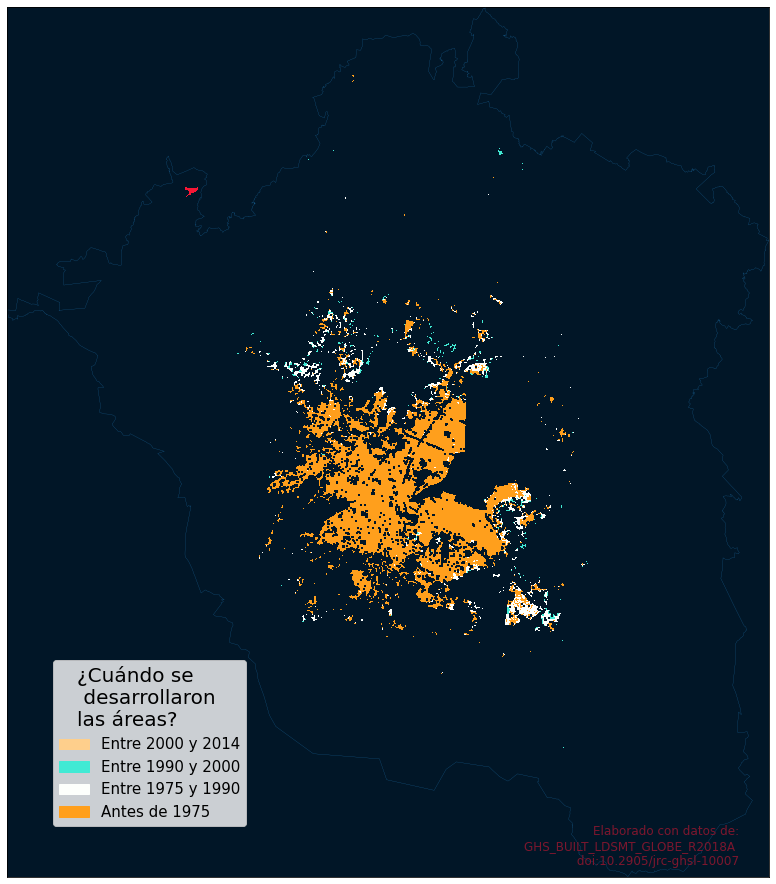

In [209]:
# use the matplotlib.pyplot function "imshow" for an image -- nir at first
fig, ax = plt.subplots(figsize=(20, 16))

# Removes ticks and labels for lat/lon
ax.tick_params(
    axis='both', bottom=False, left=False,         
    labelbottom=False, labelleft=False) 

ax.set_facecolor('#011627')

ax.imshow(image[0, :, :], cmap= cmap, extent = data_plotting_extent)
ZMVM.boundary.plot(ax=ax, linewidth = 0.2)


# Add a legend for labels
legend_labels = {"#FECF8C": "Entre 2000 y 2014",
                 "#41EAD4": "Entre 1990 y 2000",
                 "#FDFFFC": "Entre 1975 y 1990",
                 "#FF9F1C": "Antes de 1975",
                }

patches = [Patch(color=color, label=label)
           for color, label in legend_labels.items()]

ax.legend(handles=patches,loc='lower left',fontsize=15, title="¿Cuándo se\n desarrollaron \nlas áreas?",title_fontsize=20,
          bbox_to_anchor = (0.05,0.05))

left, width = 0.01, 0.95
bottom, height = 0.01, .5
right = left + width
top = bottom + height
ax.text(right, bottom, 
        'Elaborado con datos de:\nGHS_BUILT_LDSMT_GLOBE_R2018A \n doi:10.2905/jrc-ghsl-10007',
        horizontalalignment='right',
        verticalalignment='bottom',
        color = "#7C172E",
        fontsize=12,
        transform=ax.transAxes)

In [210]:
# Save figure
out_file = "ZMVM_GHSL.png"
ax.figure.savefig(out_file, bbox_inches="tight", dpi=600)